# Project 4: Humanizing Customer Complaints 

In [ ]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers
!pip install --upgrade gensim
!pip install pyLDAvis3
!pip install stop-words
!python -m pip install -U pyLDAvis
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=1f701fb5d3ace9047a1cf86d147b8309e3f3c292c31aac8fdb3ecd773335a5ae
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
  Created wheel for language-detector: filename=language_detector-5.0.2-cp36-none-any.whl size=7055 sha256=7858a6e76a76754c0720a93e355c247b84ad2db072b1031b50cde354c1888894
  Stored in directory: /root/.cache/pip/wheels/7d/37/fa/2098a4aa6c0d94d6ddff0d3a79669e12bc4f7baca8a760b3db
Successfully built language-detector
     |████████████████████████████████| 2.6MB 2.7MB/s 
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 7.6MB/s 
     |████████████████████████████████| 3.0MB 38.7MB/s 
     |████████████████████████████████| 1.1MB 39.7MB/s 
     |████████████████████████████████| 890kB 33.9MB/s 


True

# Section 1: Importing Packages and Loading Data

In [ ]:
import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Load CSV file
df= pd.read_csv(r'/content/drive/My Drive/CFPB LDA/complaints.csv')
# This step is not executable because the .csv file is not in the folder

In [ ]:
df_complaints_issue_bkp = df
df = df[df["Consumer complaint narrative"].notnull() == True]
df = df.drop_duplicates()
print(df.shape)
df['Text_Length'] = df["Consumer complaint narrative"].str.len()
#print(df[(df['Product']=='Credit reporting')]['Issue'].value_counts())
#df=df[(df['Product']=='Credit reporting') & (df['Issue'] != 'Credit monitoring or identity protection')].sort_values(by=['Issue','Text_Length']).groupby('Issue').head(1500).reset_index(drop=True)
print(df.shape)

(607972, 18)
(607972, 19)


## Section 1.1: Data Cleaning

In [ ]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)


In [ ]:
# Since we just want to do text classification with an associated label
# We only keep rows that have customer complaints in them

### Section 1.1.1: Dropping all rows that do not have Customer Complaint entries in them

In [ ]:
df.dropna(axis=0, subset=['CONSUMER_COMPLAINT_NARRATIVE'], 
          inplace=True)

### Section 1.1.2: Subsetting Dataframe for Text Multi-Classification Problem

In [ ]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_product_issue_and_complaint = df[['PRODUCT', 'ISSUE', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_product_issue_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Pickling our subsetted dataframe
with open('df_product_issue_and_complaint.pickle', 'wb') as to_write:
     pickle.dump(df_product_issue_and_complaint, to_write)

In [ ]:
# Loading our pickled subsetted dataframe
with open('df_product_issue_and_complaint.pickle', 'rb') as to_read:
    df_product_issue_and_complaint = pickle.load(to_read)

# Section 2: Understanding/Cleaning Our Data

In [ ]:
# Checking our dataframe
df_product_issue_and_complaint.info()

# Great! We have no null values in each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607972 entries, 0 to 1789655
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             607972 non-null  object
 1   ISSUE               607971 non-null  object
 2   CONSUMER_COMPLAINT  607972 non-null  object
dtypes: object(3)
memory usage: 18.6+ MB


### We have a wooping 463,991 entries in our dataframe.
This might cause our comptuer to crash. So we gotta reduce it.

In [ ]:
# Now let's take a look at some observations of what these rows look like
df_product_issue_and_complaint.head(5)

,PRODUCT,ISSUE,CONSUMER_COMPLAINT
0,Debt collection,Attempts to collect debt not owed,transworld systems inc. \nis trying to collect...
2,Debt collection,Communication tactics,"Over the past 2 weeks, I have been receiving e..."
4,Debt collection,Took or threatened to take negative or legal a...,"I received the email below, but I have never s..."
5,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,i am a victim of identity theft as previously ...
9,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


In [ ]:
print(df['PRODUCT'].value_counts())
pd.DataFrame(df.groupby(['PRODUCT','ISSUE'])['Text_Length'].describe()).to_csv('Complaint_text_dist.csv')

Credit reporting, credit repair services, or other personal consumer reports    209340
Debt collection                                                                 123624
Mortgage                                                                         69622
Credit card or prepaid card                                                      43465
Credit reporting                                                                 31588
Student loan                                                                     26986
Checking or savings account                                                      25375
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               11099
Vehicle loan or lease                                                            10575
Consumer Loan                              

In [ ]:
grouped_counts = df.groupby(['PRODUCT','ISSUE'])['CONSUMER_COMPLAINT'].count()
grouped_counts = df.groupby(['PRODUCT','ISSUE'])['CONSUMER_COMPLAINT'].count()
grouped_counts = grouped_counts.loc[grouped_counts.values<50000]
grouped_counts_flt = grouped_counts.loc[grouped_counts.values>=1000]
print(grouped_counts_flt.sort_values(ascending=True))
print(type(grouped_counts_flt))

<class 'pandas.core.series.Series'>


In [ ]:
grouped_counts_flt = pd.DataFrame(grouped_counts_flt)
grouped_counts_flt = grouped_counts_flt.reset_index()
slct_prod = grouped_counts_flt.PRODUCT.unique()
slct_issue = grouped_counts_flt.ISSUE.unique()
print(slct_prod)
print(slct_issue)

['Bank account or service' 'Checking or savings account' 'Consumer Loan'
 'Credit card' 'Credit card or prepaid card' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Mortgage' 'Payday loan, title loan, or personal loan' 'Student loan'
 'Vehicle loan or lease']
['Account opening, closing, or management' 'Deposits and withdrawals'
 'Making/receiving payments, sending money'
 'Problems caused by my funds being low' 'Using a debit or ATM card'
 'Closing an account' 'Managing an account' 'Opening an account'
 'Problem caused by your funds being low'
 'Problem with a lender or other company charging your account'
 'Managing the loan or lease' 'Problems when you are unable to pay'
 'Taking out the loan or lease' 'Billing disputes'
 'Closing/Cancelling account' 'Identity theft / Fraud / Embezzlement'
 'Other' 'Advertising and marketing, including promotional offers'
 'Cl

In [ ]:
print(slct_prod)

['Bank account or service' 'Checking or savings account' 'Consumer Loan'
 'Credit card' 'Credit card or prepaid card' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Mortgage' 'Payday loan, title loan, or personal loan' 'Student loan'
 'Vehicle loan or lease']


In [ ]:
df[df['PRODUCT'].isin(slct_prod)].PRODUCT.unique()

array(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Checking or savings account', 'Vehicle loan or lease',
       'Student loan', 'Credit card or prepaid card', 'Credit card',
       'Payday loan, title loan, or personal loan', 'Consumer Loan',
       'Credit reporting', 'Bank account or service'], dtype=object)

In [ ]:
df_slctd = df[df['PRODUCT'].isin(slct_prod) & df['ISSUE'].isin(slct_issue)]
df_slctd.info()
#df_Mortgage.rename(columns={'PRODUCT': 'Mortgage'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519418 entries, 0 to 1789655
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   DATE_RECEIVED                 519418 non-null  object
 1   PRODUCT                       519418 non-null  object
 2   SUB_PRODUCT                   480561 non-null  object
 3   ISSUE                         519418 non-null  object
 4   SUB_ISSUE                     402371 non-null  object
 5   CONSUMER_COMPLAINT            519418 non-null  object
 6   COMPANY_PUBLIC_RESPONSE       254964 non-null  object
 7   COMPANY                       519418 non-null  object
 8   STATE                         517173 non-null  object
 9   ZIP_CODE                      404595 non-null  object
 10  TAGS                          88386 non-null   object
 11  CONSUMER_CONSENT_PROVIDED     519418 non-null  object
 12  Submitted via                 519418 non-null  object
 13

In [ ]:
pd.DataFrame(df_slctd.groupby(['PRODUCT','ISSUE'])['CONSUMER_COMPLAINT'].count()).to_csv('Complaint_text_slctd_dist.csv')

In [ ]:
print(df_slctd.groupby(['PRODUCT','ISSUE'])['CONSUMER_COMPLAINT'].count().sort_values(ascending=True))

PRODUCT                                                                       ISSUE                                 
Credit reporting, credit repair services, or other personal consumer reports  Struggling to pay mortgage                     1
                                                                              Dealing with your lender or servicer           1
                                                                              Problem when making payments                   1
                                                                              Getting a credit card                          1
                                                                              Closing on a mortgage                          2
                                                                                                                         ...  
Debt collection                                                               Cont'd attempts collect debt not owed      

## Section 2.1: Exploring Consumer Complaints

In [ ]:
# # What do a few of the entries in the consumer complaint section look like?

df_Mortgage = df_product_issue_and_complaint[df_product_issue_and_complaint['PRODUCT'] == 'Mortgage']
df_Mortgage.rename(columns={'PRODUCT': 'Mortgage'}, inplace=True)

for complaint in df_Mortgage.CONSUMER_COMPLAINT[:2]:
     print(complaint)
     print('\n')

This complaint dates back to last XX/XX/XXXX during a loan modification which was done with XXXX ( Account # XXXX ) my previous loan servicer this was after a 2 month forbearance after Hurricane Irma. They had indicated a shortage to my escrow account in the loan modification documents. I was provided different information every time I spoke on the phone with a XXXX   representative. One would say I had an overage, others would say I had a shortage. The modification documents indicated at {$1900.00} shortage. I called, I emailed and wrote letters, I requested a Escrow review of my account in XXXX and XXXX and was told one would be done. They kept delaying and I finally had to sign the Modification documents on XX/XX/XXXX under duress otherwise the Modification would be withdrawn. No review of my escrow was ever done by XXXX, I discovered what appears to be an error when I reviewed the two Escrow Disclosure statements from XXXX for XXXX and XXXX. The Escrow balance for XX/XX/XXXX shows 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Jesus christ, it doesn't seem like we can glean anything very well from this wall of text either.
1. It is **immensely hard to read** because it's so long (that's what she said)   

2. Therefore, by being able to automatically correctly categorize/file customer complaints into their respective complaint type (credit reporting, loan complaint, etc.) **with just the customer input**, we can reduce the amount of computational stress and effort of an individual human.  
  
3. Additionally, a further step we can take is to have our program do some kind of summarization or pseudo-summarization (tf-idf) on the whole wall of text that one has to read.

**Therefore, we verify our model based on accuracy this time.**


## Section 2.2: Exploring Product

In [ ]:
# Exploring the number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_issue_and_complaint['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_issue_and_complaint['PRODUCT'].nunique())
print('--------------')

--------------
Categories in PRODUCT column:
--------------

['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Money transfer, virtual currency, or money service' 'Mortgage'
 'Checking or savings account' 'Vehicle loan or lease' 'Student loan'
 'Credit card or prepaid card' 'Credit card'
 'Payday loan, title loan, or personal loan' 'Consumer Loan' 'Payday loan'
 'Credit reporting' 'Other financial service' 'Bank account or service'
 'Money transfers' 'Prepaid card' 'Virtual currency'] 

--------------
# of unique categories:  18
--------------


### We see that some of the categories are repeated.
* 'Credit card' vs 'Credit card or prepaid card'
* 'Prepaid card' vs 'Credit card or prepaid card'
* 'Credit reporting' vs 'Credit reporting, credit repair services, or other personal consumer reports'
* 'Money transfers' vs 'Money transfer, virtual currency, or money service'
* 'Payday loan' vs 'Payday loan, title loan, or personal loan'
* 'Virtual currency' vs 'Money transfer, virtual currency, or money service' 'Money transfers'

There seems to be some sort of overlap between the categories, and I have no freakin clue why it is put this way. So why don't we simplify our problem by combining these categories together?  
  
But of course - let us do some **data visualizations** to gain more insights about the spread of our categories, shall we? 
  
### OMG WOW DATA VISUALIZATION YOU SAY??

### Section 2.2.1: Data Visualization on Categories in PRODUCT

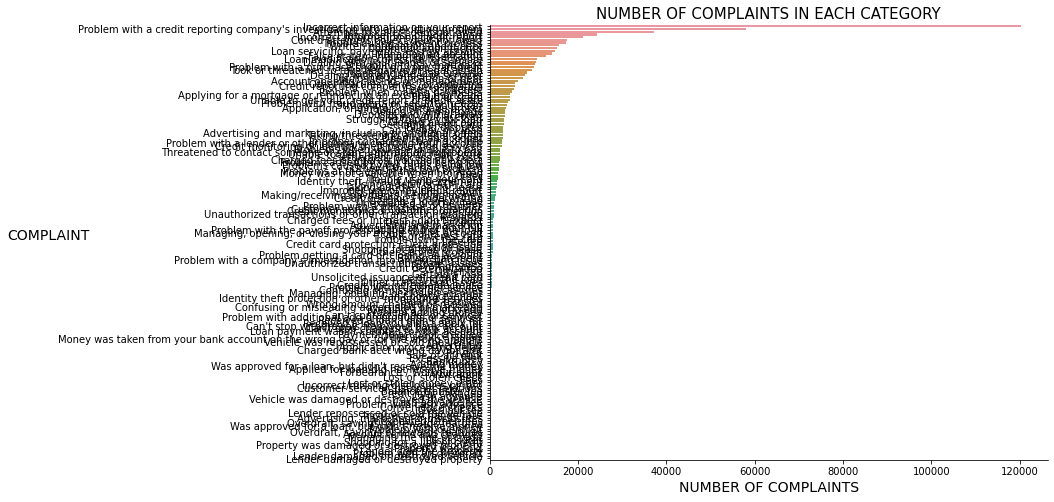

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_product_issue_and_complaint, 
                   order=df_product_issue_and_complaint['ISSUE'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

In [ ]:
print('Number of rows in Dataframe: ', len(df_product_issue_and_complaint))


Number of rows in Dataframe:  607972


This is seriously way too huge. Let's just scope our problem down into more bite-sized chunks our computer can actually handle.

### We observe some aggregated columns here.
Let's drop those columns first. Since we want a more accurate/specific label for our predictions. The columns are:
* Credit reporting, credit repair services, or other personal consumer reports
* Credit card or prepaid card
* Money transfer, virtual currency, or money service
* Payday loan, title loan, or personal loan

### Section 2.2.2: DataFrame Reduction (else we won't even be able to do processing)

#### Section 2.2.2.1: Category Dropping

In [ ]:
# Pre-drop category value_counts
df_product_issue_and_complaint.PRODUCT.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    209340
Debt collection                                                                 123624
Mortgage                                                                         69622
Credit card or prepaid card                                                      43465
Credit reporting                                                                 31588
Student loan                                                                     26986
Checking or savings account                                                      25375
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               11099
Vehicle loan or lease                                                            10575
Consumer Loan                              

In [ ]:
# Dropping rows with the aggregated columns
df_product_issue_and_complaint.drop(
    df_product_issue_and_complaint[
    df_product_issue_and_complaint.PRODUCT == 
    'Credit reporting, credit repair services, or other personal consumer reports'].index, 
    inplace=True) # credit_aggregated

df_product_issue_and_complaint.drop(
    df_product_issue_and_complaint[
    df_product_issue_and_complaint.PRODUCT == 
    'Credit card or prepaid card'].index, 
    inplace=True) # cred_or_prepaid

df_product_issue_and_complaint.drop(
    df_product_issue_and_complaint[
    df_product_issue_and_complaint.PRODUCT == 
    'Money transfer, virtual currency, or money service'].index, 
    inplace=True) # money_virtual_service

df_product_issue_and_complaint.drop(
    df_product_issue_and_complaint[
    df_product_issue_and_complaint.PRODUCT == 
    'Payday loan, title loan, or personal loan'].index, 
    inplace=True) # payday_title_personal_loan

#### Visualizing Leftover Categories (after dropping the ones stated above)

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

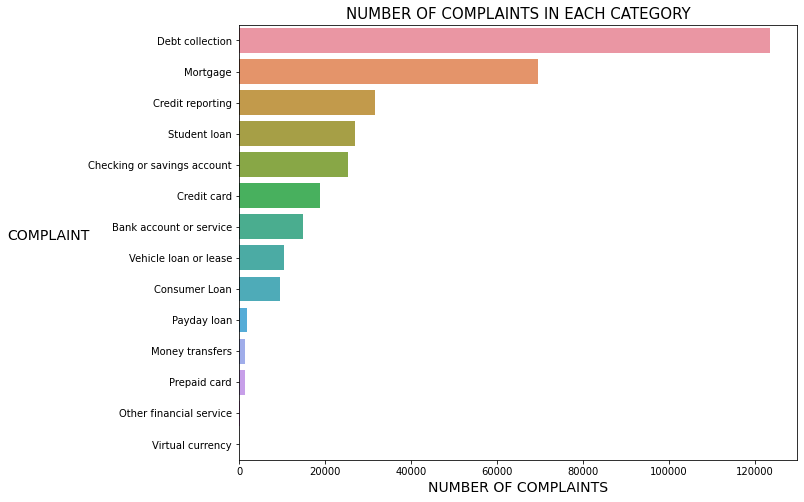

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_issue_and_complaint, 
                   order=df_product_issue_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

In [ ]:
# Checking Length of df now
df_product_issue_and_complaint.info()

# It's still quite a sizeable amount that my computer can't take. So we have to drop more.
# We want to reduce it to less than 50k entries

# LOL good job surface pro

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335967 entries, 0 to 1789655
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             335967 non-null  object
 1   ISSUE               335967 non-null  object
 2   CONSUMER_COMPLAINT  335967 non-null  object
dtypes: object(3)
memory usage: 20.3+ MB


In [ ]:
df_product_issue_and_complaint.PRODUCT.value_counts()

Debt collection                123624
Mortgage                        69622
Credit reporting                31588
Student loan                    26986
Checking or savings account     25375
Credit card                     18838
Bank account or service         14885
Vehicle loan or lease           10575
Consumer Loan                    9473
Payday loan                      1746
Money transfers                  1497
Prepaid card                     1450
Other financial service           292
Virtual currency                   16
Name: PRODUCT, dtype: int64

#### Section 2.2.2.2: Combining Categories

In [ ]:
## Combining Loans together to make this a simplier classification problem

df_product_issue_and_complaint.replace('Student loan', 'Loan', inplace=True)
df_product_issue_and_complaint.replace('Consumer Loan', 'Loan', inplace=True)
df_product_issue_and_complaint.replace('Payday loan', 'Loan', inplace=True)
df_product_issue_and_complaint.replace('Vehicle loan or lease', 'Loan', inplace=True)

# Placing Virtual currency into other financial service
df_product_issue_and_complaint.replace('Virtual currency', 'Other financial service', inplace=True)

#### Section 2.2.2.3: Leftover Categories Dataframe Reduction

In [ ]:
df_product_issue_and_complaint.PRODUCT.value_counts()

Debt collection                123624
Mortgage                        69622
Loan                            48780
Credit reporting                31588
Checking or savings account     25375
Credit card                     18838
Bank account or service         14885
Money transfers                  1497
Prepaid card                     1450
Other financial service           308
Name: PRODUCT, dtype: int64

In [ ]:
df_product_issue_and_complaint.info()  # 290k rows. jesus christ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335967 entries, 0 to 1789655
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             335967 non-null  object
 1   ISSUE               335967 non-null  object
 2   CONSUMER_COMPLAINT  335967 non-null  object
dtypes: object(3)
memory usage: 20.3+ MB


In [ ]:
# Reducing dataframe to 30k entries
# Need to reduce all categories by 90%

percentage_reduction = 0.9

# Debt Collection Reduction
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint.drop(
    df_product_issue_and_complaint[df_product_issue_and_complaint['PRODUCT'] == 'Debt collection'].sample(frac=percentage_reduction).index)

# Mortgage Reduction
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Mortgage'].sample(frac=percentage_reduction).index)

# Loan
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Loan'].sample(frac=percentage_reduction).index)

# Credit reporting
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Credit reporting'].sample(frac=percentage_reduction).index)

# Credit card
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Credit card'].sample(frac=percentage_reduction).index)

# Checking or savings account
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Checking or savings account'].sample(frac=percentage_reduction).index)

# Bank account or service
df_product_issue_and_complaint_reduced = \
df_product_issue_and_complaint_reduced.drop(
    df_product_issue_and_complaint_reduced[
        df_product_issue_and_complaint_reduced['PRODUCT'] == 'Bank account or service'].sample(frac=percentage_reduction).index)

# # Money transfers (too little to be reduced)
# df_product_issue_and_complaint_reduced = \
# df_product_issue_and_complaint_reduced.drop(
#     df_product_issue_and_complaint_reduced[
#         df_product_issue_and_complaint_reduced['PRODUCT'] == 'Money transfers'].sample(frac=.9).index)

# # Prepaid card (too little to be reduced)
# df_product_issue_and_complaint_reduced = \
# df_product_issue_and_complaint_reduced.drop(
#     df_product_issue_and_complaint_reduced[
#         df_product_issue_and_complaint_reduced['PRODUCT'] == 'Prepaid card'].sample(frac=.9).index)

# # Other financial service (too little to be reduced)
# df_product_issue_and_complaint_reduced = \
# df_product_issue_and_complaint_reduced.drop(
#     df_product_issue_and_complaint_reduced[
#         df_product_issue_and_complaint_reduced['PRODUCT'] == 'Other financial service'].sample(frac=.9).index)

In [ ]:
df_product_issue_and_complaint_reduced.PRODUCT.value_counts()

Debt collection                12362
Mortgage                        6962
Loan                            4878
Credit reporting                3159
Checking or savings account     2537
Credit card                     1884
Money transfers                 1497
Bank account or service         1489
Prepaid card                    1450
Other financial service          308
Name: PRODUCT, dtype: int64

In [ ]:
df_product_issue_and_complaint_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36526 entries, 53 to 1789648
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PRODUCT             36526 non-null  object
 1   ISSUE               36526 non-null  object
 2   CONSUMER_COMPLAINT  36526 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [ ]:
# Exploring the new number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_issue_and_complaint_reduced['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_issue_and_complaint_reduced['PRODUCT'].nunique())
print('--------------')

# Great! Now we are down to 10 classes. 

--------------
Categories in PRODUCT column:
--------------

['Mortgage' 'Checking or savings account' 'Debt collection' 'Loan'
 'Credit reporting' 'Other financial service' 'Credit card'
 'Money transfers' 'Prepaid card' 'Bank account or service'] 

--------------
# of unique categories:  10
--------------


### Section 2.2.3: Data Visualizing on newly combined classes

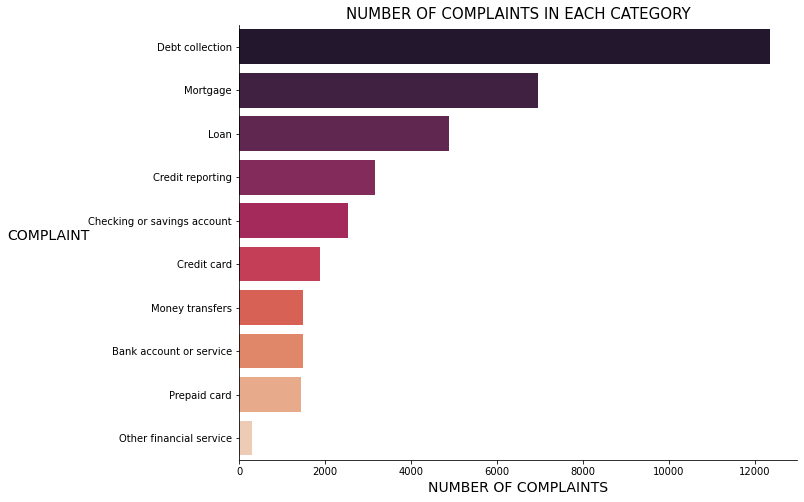

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_issue_and_complaint_reduced, 
                   order=df_product_issue_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

We can see from the graph that there lies a major class imbalance (again)  
We have to deal with this when we are going to use our model for prediction  
Now we are doing multilabel prediction. HOORAY!

### Section 2.2.4: Label Encoding Categories

In [ ]:
# Applying encoding to the PRODUCT column
df_product_issue_and_complaint_reduced['PRODUCT_ID'] = df_product_issue_and_complaint_reduced['PRODUCT'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the PRODUCT column


# Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
category_id_df = df_product_issue_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

# New dataframe
df_product_issue_and_complaint_reduced.head(10) 

,PRODUCT,ISSUE,CONSUMER_COMPLAINT,PRODUCT_ID
53,Mortgage,Closing on a mortgage,We have already tried to contact the company w...,0
60,Checking or savings account,Managing an account,I open checking account in Citibank in XXXX an...,1
202,Debt collection,Took or threatened to take negative or legal a...,"On XX/XX/2019, I received the letter from Bila...",2
455,Mortgage,Trouble during payment process,For many years I have been facing an execution...,0
828,Debt collection,Attempts to collect debt not owed,XXXX XXXX XXXX ( 01 XXXX XXXX XXXX XXXX XXXX )...,2
941,Debt collection,Attempts to collect debt not owed,THIS COMPANY IS REPORTING AN ACCOUNT ON MY CRE...,2
1015,Debt collection,Took or threatened to take negative or legal a...,A year ago I dealt with a scammer that got me ...,2
1234,Mortgage,Trouble during payment process,In XX/XX/XXXX a tree from neighbor yard fell c...,0
1274,Debt collection,False statements or representation,I had a checking 's account with US bank. I ha...,2
1447,Debt collection,Written notification about debt,Received a letter from XXXX XXXX XXXX XXXX on ...,2


In [ ]:
# We still get the same length as per the original df.
len(df_product_issue_and_complaint_reduced)

36526

Now that we have encoded our columns, time to move on to the next step -- cleaning the fricken text data  
But let's save our dataframe here so we don't run into memory issues later and we can start from a new starting point fruther down the notebook

In [ ]:
# # Pickling reduced dataframe
# with open('df_product_issue_and_complaint_reduced.pickle', 'wb') as to_write:
#     pickle.dump(df_product_issue_and_complaint_reduced, to_write)

In [ ]:
# Loading Pickled DataFrame
with open('df_product_issue_and_complaint_reduced.pickle', 'rb') as to_read:
    df_product_issue_and_complaint_reduced = pickle.load(to_read)

FileNotFoundError: ignored

In [ ]:
# Reviewing our Loaded Dataframe
print(df_product_issue_and_complaint_reduced.info())
print('--------------------------------------------------------------------------------------')
print(df_product_issue_and_complaint_reduced.head().to_string())

### Section 2.2.5: Text Pre-Processing

In [ ]:
# Looking at a sample text
sample_complaint = list(df_product_issue_and_complaint_reduced.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

In [ ]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

Ok so basically, we can trust the stop_word removal from tfidf.   
Through the tests, we see that it removes punctuations and also all the stopwords.   
(I deleted these because they were seriously taking up a lot of space on my jupyter notebook)  
Spellchecker might also mess up some words, especially with bank names like Citi for example  
Thus changing the semantic meaning of the word.  
  
Therefore, we are going to just use tfidf just as it is.  
It's pretty amazing, really.  
  
Great! We can start building some shit!  

# Section 3: Model/Classifier Selection

## Section 3.1: Train/StratifiedCV/Test split

In this section, we also prepare the model for text pre-processing. This is handled by our handydandy Tfidfvecotirzer with the stop_words and such. As we have tested above, it also ignores punctuation so it really is quite a catch-all package that cleans our text really well for the purposes of doing text classification

In [ ]:
# Split the data into X and y data sets
X, y = df_product_issue_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_issue_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

In [ ]:
# Split the data into X and y data sets
X, y = df_product_issue_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_issue_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

In [ ]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)


# # StratifiedKFold -> Split 5
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Section 3.2: Baseline Model - Train/Stratified CV with MultinomialNB()

In [ ]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)

In [ ]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })

In [ ]:
# ## Data Science Story:
# # Testing on MultinomialNB first

# # Initialize Model Object
# mnb = MultinomialNB()

# results_cv_stratified_1gram = metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1')
# results_cv_stratified_2gram = metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2')

In [ ]:
# results_cv_stratified_1gram

In [ ]:
# results_cv_stratified_2gram

## Section 3.3: Further Train/Straitified CV with other Models

### Section 3.3.1: 1-gram

In [ ]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

In [ ]:
results_cv_straitified_1gram

In [ ]:
# # Saving our results because I don't wanna re-train the whole damn thing
# with open('results_cv_straitified_1gram_df.pickle', 'wb') as to_write:
#     pickle.dump(results_cv_straitified_1gram, to_write)

In [ ]:
# Loading our pickled results
with open('results_cv_straitified_1gram_df.pickle', 'rb') as to_read:
    results_cv_straitified_1gram = pickle.load(to_read)

### Section 3.3.2: 2-gram (Keep running into memory issues, therefore, this will not be tested anymore)

In [ ]:
#### Keep running into memory issues with 2-gram. Therefore, will not test it anymore


## Testing on all Models using 2-gram 

# # Initialize Model Object
# gnb = GaussianNB()
# mnb = MultinomialNB()
# logit = LogisticRegression(random_state=seed)
# knn = KNeighborsClassifier()
# decisiontree = DecisionTreeClassifier(random_state=seed)
# randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
# linearsvc = LinearSVC()

# # to concat all models
# results_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),
#                                            metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),
#                                            metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),
#                                            metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),
#                                            metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val, 5, 'LinearSVC2')
#                                           ], axis=0).reset_index()

In [ ]:
# results_cv_straitified_2gram

### Section 3.3.3: Using GloVe50d

Each complaint is mapped to a feature vector by averaging the word embeddings of all words in the review. These features are then fed into the defined function above for train/cross validation.

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

glove_file = glove_dir = 'glove.6B.50d.txt'
w2v_output_file = 'glove.6B.50d.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_50d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_50d.pickle', 'wb') as to_write:
    pickle.dump(glove_model_50d, to_write)

In [ ]:
# Load pickled glove_model
with open('glove_model_50d.pickle', 'rb') as to_read:
    glove_model_50d = pickle.load(to_read)
    
num_features = 50 # depends on the pre-trained model you are loading

In [ ]:
def complaint_to_wordlist(review, remove_stopwords=False):
    """
    Convert a complaint to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words    # list of tokenized and cleaned words

In [ ]:
# num_features refer to the dimensionality of the model you are using
# model refers to the trained word2vec/glove model
# words refer to the words in a single document/entry

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),  # creates a zero matrix of (num_features, )
                           dtype="float32")  # pre-initialize (for speed)
    
    # Initialize a counter for the number of words in a complaint
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:   # for each word in the list of words
        if word in index2word_set:   # if each word is found in the words known to the model
            nwords = nwords + 1.     # add 1 to nwords
            feature_vec = np.add(feature_vec, model[word])   
    
    # Divide by the number of words to get the average 
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec

In [ ]:
# complaints refers to the whole corpus you intend to put in. 
# Therefore you need to append all these info from your df into a list first

def get_avg_feature_vecs(complaints, model, num_features):
    """
    Calculate average feature vectors for ALL complaints
    """
    # Initialize a counter for indexing 
    counter = 0
    
    # pre-initialize (for speed)
    complaint_feature_vecs = np.zeros((len(complaints),num_features), dtype='float32')  
    
    for complaint in complaints: # each complaint is made up of tokenized/cleaned/stopwords removed words
        complaint_feature_vecs[counter] = make_feature_vec(complaint, model, num_features)
        counter = counter + 1
    return complaint_feature_vecs

In [ ]:
# Tokenizing and vectorizing our Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_50d, num_features)

# Tokenizing and vectorizing our Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_50d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove50d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove50d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove50d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove50d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove50d')
    ], axis=0).reset_index()

In [ ]:
# Saving Results into a DF
with open('results_cv_straitified_glove50d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove50d, to_write)

In [ ]:
# Opening Results
with open('results_cv_straitified_glove50d.pickle', 'rb') as to_read:
    results_cv_straitified_glove50d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove50d

### Section 3.3.4: Using GloVe100d

In [ ]:
del glove_model_50d, results_cv_straitified_glove50d

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 100 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_100d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_100d, to_write)

In [ ]:
# Load pickled glove_model
with open('glove_model_100d.pickle', 'rb') as to_read:
    glove_model_100d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_100d, num_features)

# For Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_100d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove100d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove100d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove100d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove100d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove100d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove100d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove100d, to_write)

In [ ]:
# Opening Results
with open('results_cv_straitified_glove100d.pickle', 'rb') as to_read:
    results_cv_straitified_glove100d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove100d

### Section 3.3.5: Using GloVe200d

In [ ]:
del glove_model_100d, results_cv_straitified_glove100d

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 200 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_200d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_200d, to_write)

In [ ]:
# Load pickled glove_model
with open('glove_model_200d.pickle', 'rb') as to_read:
    glove_model_200d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_200d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove200d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove200d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove200d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove200d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove200d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove200d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove200d, to_write)

In [ ]:
# Opening Results
with open('results_cv_straitified_glove200d.pickle', 'rb') as to_read:
    results_cv_straitified_glove200d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove200d

### Section 3.3.6: Using GloVe300d

In [ ]:
del glove_model_200d, results_cv_straitified_glove200d

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 300 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_300d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_300d, to_write)

In [ ]:
# Load pickled glove_model
with open('glove_model_300d.pickle', 'rb') as to_read:
    glove_model_300d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove300d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove300d, to_write)

In [ ]:
# Opening Results
with open('results_cv_straitified_glove300d.pickle', 'rb') as to_read:
    results_cv_straitified_glove300d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove300d

### Section 3.3.7: Using GoogleNews Word2Vec300d

In [ ]:
del glove_model_300d, results_cv_straitified_glove300d

In [ ]:
## Using pre-trained GoogleNews Word2Vec
# download from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

num_features = 300 # depends on the pre-trained model you are loading

# Path to where the word2vec file lives
google_vec_file = 'GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model_300d = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
# it is just loading all the different weights (embedding) into python


# Pickle word2vec 300d model so we don't have to do the above steps again and keep the damn file in our folder
with open('word2vec_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(word2vec_model_300d, to_write)

In [ ]:
# Load pickled glove_model
with open('word2vec_model_300d.pickle', 'rb') as to_read:
    word2vec_model_300d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, word2vec_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_word2vec300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_word2vec300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_word2vec300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_word2vec300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_word2vec300d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_word2vec300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_word2vec300d, to_write)

In [ ]:
# Opening Results
with open('results_cv_straitified_word2vec300d.pickle', 'rb') as to_read:
    results_cv_straitified_word2vec300d = pickle.load(to_read)

In [ ]:
results_cv_straitified_word2vec300d

In [ ]:
del word2vec_model_300d, results_cv_straitified_word2vec300d

### Section 3.3.8: Compiling Results

In [ ]:
results_compiled.columns

In [ ]:
results_compiled = pd.concat([results_cv_straitified_1gram,
                           results_cv_straitified_glove50d,
                           results_cv_straitified_glove100d,
                           results_cv_straitified_glove200d,
                           results_cv_straitified_glove300d,
                           results_cv_straitified_word2vec300d]).reset_index().drop(['level_0','index'],axis=1)

In [ ]:
with open('results_compiled.pickle', 'wb') as to_write:
    pickle.dump(results_compiled, to_write)

results_compiled

#### Sorting in Descending order by Accuracy

In [ ]:
# Sorting results to see which one gives us the best results
results_compiled_sorted_by_accuracy = results_compiled.sort_values(by='Accuracy', ascending=False)

with open('results_compiled_sorted_by_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_compiled_sorted_by_accuracy, to_write)

results_compiled_sorted_by_accuracy

In [ ]:
# Retrieving the Model that provides the highest Accuracy
results_highest_accuracy = results_compiled[results_compiled.Accuracy == results_compiled.Accuracy.max()]

with open('results_highest_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_highest_accuracy, to_write)

results_highest_accuracy

In [ ]:
# We see from the above that LogisiticRegression and LinearSVC on 1-gram gives pretty good results.
# But LogReg is the best. So let's go with that!

# Now let us do the final test!!
# Pretty decent accuracy, actually.
# I want to try 2-gram but my computer just simply won't be able to handle it

# Section 4: Final Test - 80% Train/Test split

## Section 4.1: Splitting to 80% Train and 20% unseen data

In [ ]:
# Split the data into X and y data sets
X, y = df_product_issue_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_issue_and_complaint_reduced.PRODUCT
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

In [ ]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [ ]:
# Initializing our chosen logreg model
logit = LogisticRegression()

# Fitting our model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

In [ ]:
# Pickle trained Model for use in Flask App
with open('logit_finalized.pickle', 'wb') as to_write:
    pickle.dump(logit_finalized, to_write)

In [ ]:
# Now we have a pickled trained model, we can use this for our flask app!
with open('logit_finalized.pickle', 'rb') as to_read:
    logit_finalized = pickle.load(to_read)

In [ ]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
    category_id_df = df_product_issue_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
    id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.PRODUCT.values, 
                   yticklabels=category_id_df.PRODUCT.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_issue_and_complaint_reduced, 
                   order=df_product_issue_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

In [ ]:
with open('results_highest_accuracy.pickle', 'rb') as to_read:
    results_highest_accuracy = pickle.load(to_read)

results_highest_accuracy

# Score model
print("---------------------------------------------------------")
print("LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:")
print("---------------------------------------------------------")
print('\n')
print('Train/Cross-Validation Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(results_highest_accuracy.Accuracy.max()))
print('Final Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('\n')
print('Macro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))
print('\n')
print('Micro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('\n')
print('Weighted Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\n')
print('Classification report for LogisticRegression (1-gram):\n {}'.format(classification_report(y_test, 
                                                                                             y_pred,
                                                                                             target_names=df_product_issue_and_complaint_reduced.PRODUCT.unique())))
print('Confusion Matrix for LogisticRegression (1-gram):\n'.format(conf_matrix(y_test, y_pred)))

In [ ]:
conf_matrix(y_test, y_pred)
plt.savefig('confusion_matrix', transparent=True)

In [ ]:
# Although our model is not going to be correct 100% of the time, it does a pretty good job

In [ ]:
# Just leaving this here for presentation purposes. 
# However, we are already doing the stratified split in the function itself

# # StratifiedKFold
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)
# kf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)

# Section 5: Testing out Predictions on Random Complaints

In [ ]:
# These are the ONLY packages we need to use from this point forward!
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# Loading our saved models
# Consider training on the whole data instead now?
with open('fitted_tfidf_to_use.pickle', 'rb') as to_read:  # loading the fitted tfidf with our 80% trained data
    fitted_tfidf_to_use = pickle.load(to_read)
    
with open('logit_finalized.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

## Section 5.1: Random Complaint 1

In [ ]:
# Using our models

complaint = """
omg where is my money
aosidnoiandnaiosdnasd This is bullshit!! where is my money!!!
I TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.
WHAT KIND OF A BANK ARE YOU?
ARE YOU A BANK OR A THIEF?"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint = fitted_tfidf_to_use.transform([complaint])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint)
y_customized_prediction[0]

## Section 5.1: Random Complaint 2

In [ ]:
# Using our models

complaint_2 = """
I borrowed money from you guys but it seems that the interest terms are unclear?
Please shed some more light on this because i seem to be overcharged this month and I don't want to pay more than I should
"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_2 = fitted_tfidf_to_use.transform([complaint_2])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_2)
y_customized_prediction

In [ ]:
# Not bad! Our model actually does do a pretty good job at predicting

## Section 5.2: Random Complaint 3 with no relevance at all

What about _completely_ irrelevant topics?

In [ ]:
# Using our models

complaint_3 = """
I love macdonalds"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_3 = fitted_tfidf_to_use.transform([complaint_3])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_3)
y_customized_prediction

## Section 5.3: Random Complaint 4 with no relevance at all

In [ ]:
# Using our models

complaint_4 = """
Pair programming is not fun"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_4 = fitted_tfidf_to_use.transform([complaint_4])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_4)
y_customized_prediction

### Comments:
It seems like everything that has no relevance tends to be classified as Debt Collection.  
So yes - there are cases therein which the model can incorrectly classify the Complaint.  
However, although our model is not going to be correct 100% of the time, it does do a pretty good job.  
It can handle very weird complaints where we throw in a complain that doesn't make a lot of sense.  
  
### Breaking our Model down:
It's great that we know that our model can do classifcation, but HOW does it do it? Let's dissect it and check what key words the model looks out for to classify a complaint.

# Section 6: Highest Occuring Words in each column

In [ ]:
# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf2.fit_transform(df_product_issue_and_complaint_reduced.CONSUMER_COMPLAINT).toarray()
# Labelling our data
labels = df_product_issue_and_complaint_reduced.PRODUCT_ID

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

In [ ]:
category_to_id

In [ ]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf2.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

### Section 69.1: Word Cloud (Most frequently occuring words depicted in a picture)

# Section 7: Flask App

In [ ]:
## Do a flask app that returns the predicted category
# and the percentage probability of each category
# with an input

### Please refer to the flask_app folder if you are interested in finding out how to create the app!